In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Functions

In [124]:
def plot_channels(X, y, start=0, end=1, col_start=0, col_end=15, figsize=(20,10), plot_label=True):
    data_len = len(X)
    start_index, end_index = int(data_len*start), int(data_len*end)
    X, y = X.iloc[start_index:end_index], y.iloc[start_index:end_index]
    fig, ax = plt.subplots(figsize=figsize)
    X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
    y = MinMaxScaler().fit_transform(y.values.reshape(-1,1))
    for col in X.columns[col_start:col_end]:
        ax.plot(X[col], label=col)
    if plot_label:
        ax.plot(y, label='label')
    plt.legend()
    
def compute_fft(sig, fs):
    period_s = 1/fs
    freq_components = np.fft.rfft(sig)
    fft_freqs = np.fft.rfftfreq(len(sig), period_s)   
    return fft_freqs, freq_components

def plot_freqs(X, fs):
    n_features = X.shape[1]
    fig, ax = plt.subplots(n_features, 1, figsize=(12, n_features*3))
    for i in range(n_features):
        col_name = X.columns[i]
        fft_freqs, freq_components = compute_fft(X[col_name], fs)
        ax[i].plot(fft_freqs[1:], np.abs(freq_components)[1:], color='red')
        ax[i].set_title(label=col_name, fontsize=15)
    plt.tight_layout()
    plt.show();

def compute_fs(time_array, time_unit=1):
    return 1/pd.Series(time_array).diff(1).mean()

In [115]:
data = pd.read_csv('../data/two_motions_opto_preprocessed.csv', sep='\t').drop(columns=['Unnamed: 0'])
data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,time_s,trigger
0,37292.0,25887.0,25235.0,42693.0,16259.0,25221.0,31435.0,20880.0,11206.0,37417.0,...,18080.0,33607.0,18842.0,19414.0,36984.0,21346.0,26338.0,36961.0,0.014875,0.0
1,36506.0,25552.0,23993.0,43510.0,16740.0,24965.0,31605.0,21084.0,13836.0,35495.0,...,18185.0,32452.0,17903.0,19262.0,36560.0,21019.0,26233.0,36951.0,0.045000,0.0


estimated data frequency: 33.250200951980986hz


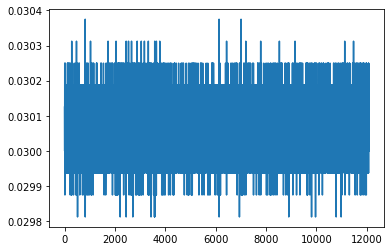

In [116]:
data_fs = compute_fs(data['time_s'])
print(f'estimated data frequency: {data_fs}hz')
plt.plot(range(len(data['time_s'])), pd.Series(data['time_s']).diff(1));

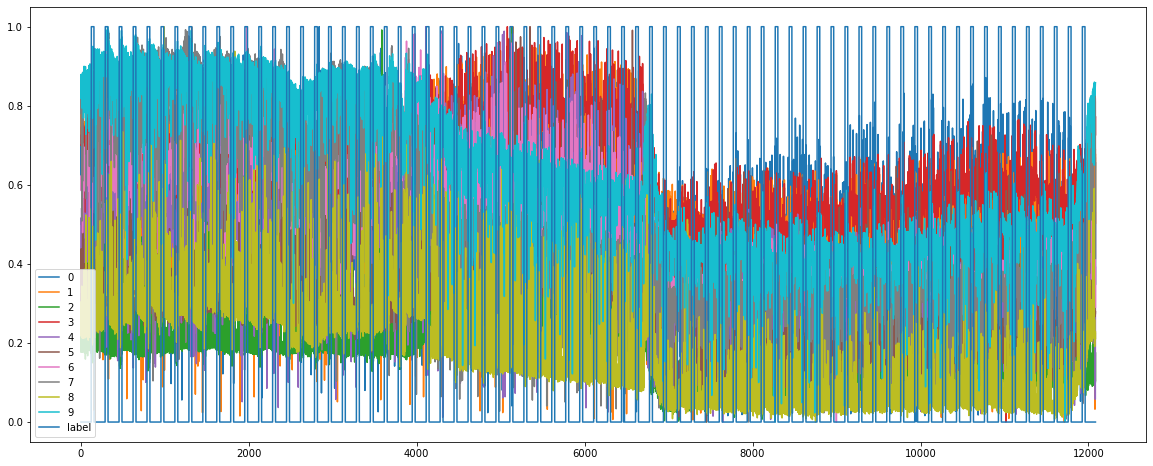

In [117]:
X = data.drop(columns=['time_s', 'trigger'])
y = data['trigger']
y = y.shift(5).fillna(0)
X = pd.DataFrame(MinMaxScaler().fit_transform(X))
plot_channels(X, y, start=0.0, end=1.0 ,col_start=0, col_end=10, figsize=(20,8), plot_label=True)

In [118]:
X.describe().iloc[2,:]

0     0.091273
1     0.125233
2     0.091302
3     0.114410
4     0.113245
5     0.106181
6     0.143320
7     0.229485
8     0.122202
9     0.195218
10    0.104198
11    0.184028
12    0.123336
13    0.237554
14    0.115981
15    0.153826
16    0.124562
17    0.146383
18    0.179313
19    0.139420
20    0.110168
21    0.124789
22    0.133487
23    0.100904
24    0.099291
25    0.121335
26    0.120708
27    0.133979
28    0.221221
29    0.104567
30    0.231197
31    0.287139
32    0.271856
33    0.230977
34    0.072771
35    0.216807
36    0.240905
37    0.241377
38    0.159136
39    0.274873
40    0.093843
41    0.292418
42    0.316620
43    0.282175
44    0.119526
45    0.238257
Name: std, dtype: float64

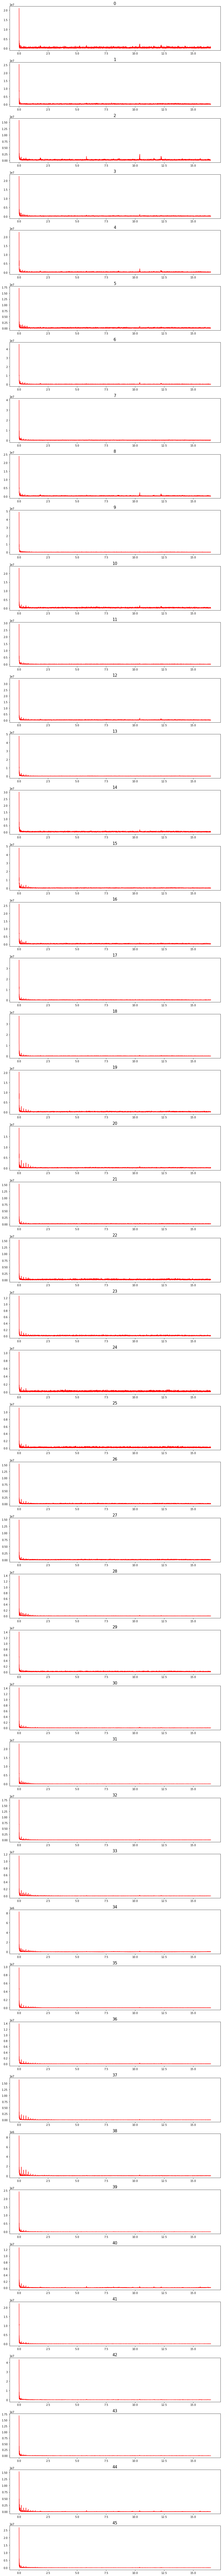

In [125]:
X = data.drop(columns=['time_s', 'trigger'])
plot_freqs(X-X.mean(), fs=int(data_fs))

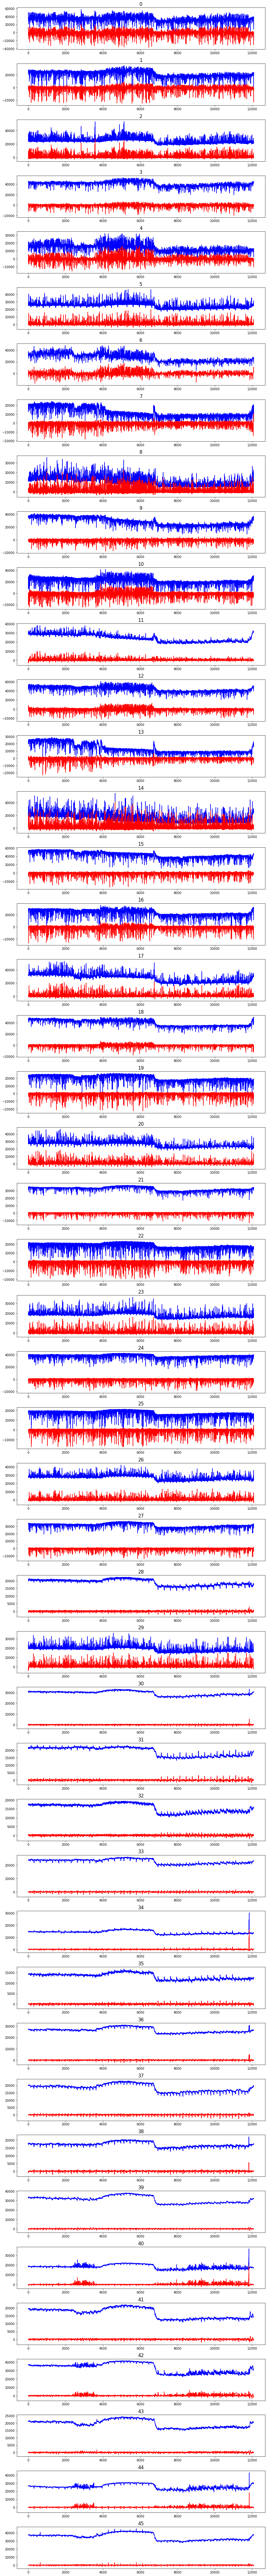

In [128]:

from scipy.signal import filtfilt, butter


def get_filtered_channel(data, channel_name, cutoff, fs):
    signal = data[channel_name]
    nyq = 0.5 * fs
    low=cutoff/nyq
    b, a = butter(6, low, 'highpass')
    return filtfilt(b, a, signal)


def plot_channels_filtered(X, fs, cutoff=0.2):
    n_features = X.shape[1]
    fig, ax = plt.subplots(n_features, 1, figsize=(12, n_features*2.5))
    X_filt = X.copy()
    for i in range(n_features):
        col_name = X.columns[i]
        filt_ch = get_filtered_channel(X, col_name, cutoff, fs)
        X_filt[col_name] = filt_ch
        ax[i].plot(X[col_name], color='blue')
        ax[i].plot(filt_ch, color='red')
        ax[i].set_title(label=col_name, fontsize=15)
    plt.tight_layout()
    plt.show();
    return X_filt


X_filt = plot_channels_filtered(X, fs=32);


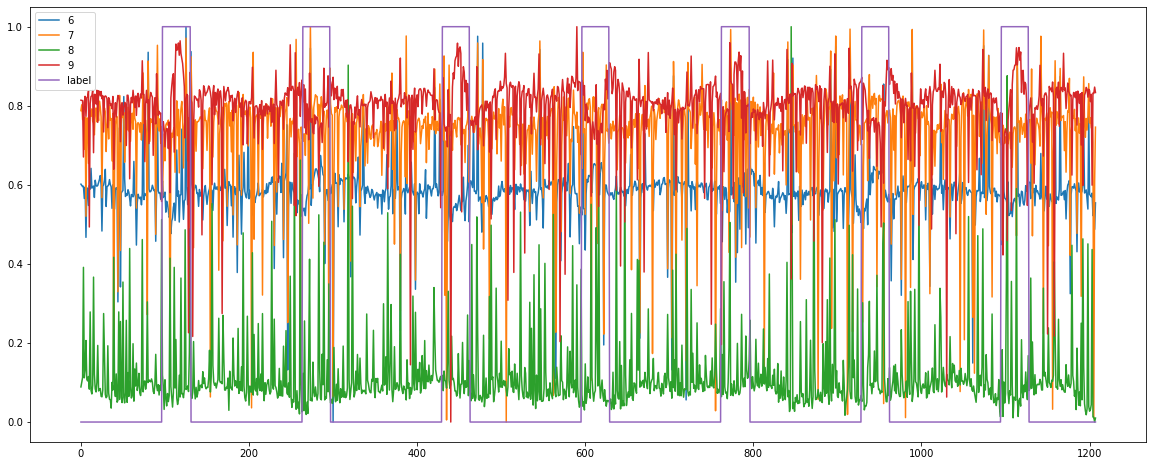

In [121]:
plot_channels(X_filt, y, start=0.8, end=.9 ,col_start=6, col_end=10, figsize=(20,8), plot_label=True)